# Using Word Embeddings for Semantic Analysis of Classifiers

The first step is to import the relevant modules and classes. The NLTK library is used to manipulate the data from the corpus that we're going to use, and Word2Vec is used to convert the corpus vocabulary into vectors that can be manipulated for the analysis.

In [1]:
import os
import pickle
from nltk.corpus import PlaintextCorpusReader
from nltk.collocations import BigramCollocationFinder as finder, BigramAssocMeasures as measures
from gensim.models import Word2Vec

The next step is to navigate to the folder containing the raw corpus, and importing it using the `PlaintextCorpusReader` class from the `nltk.corpus` module.
The corpus we're using is the SCH Corpus, a publicly-available corpus of Hmong text that derives from forum posts online on soc.culture.hmong Usenet.

In [2]:
os.chdir(os.path.expanduser(os.path.join('~','sch_corpus')))

hmong = PlaintextCorpusReader('.', '.*').sents()

Next, we use the Word2Vec class from gensim.models to create our word vectors. The argument `window` is set to 10 to indicate that a window of 10 around the chosen word should be used to train the vectors. `size` is the size of the vector for each word, set here to 150 to enable a reasonably robust yet compact set of vectors. `iter` is the number of iterations used in training; here, I've set it to 50.

In [7]:
model = Word2Vec(sentences=hmong, window=10, size=150, iter=50, workers=10)

In [3]:
import pickle
os.chdir(os.path.expanduser(os.path.join(os.path.join('~', 'python_workspace'), 'hmong_clf_graph')))
f = open('Word2Vec_model_50.pkl', 'rb')
model = pickle.load(f)
f.close()

This step uses BigramCollocationFinder from nltk.collocations to find all the bigram collocations in the corpus. We do this because we want to have nouns that occur with the Hmong classifier _tus_.

In [4]:
bigrams = finder.from_words([w for sent in hmong for w in sent])

Next, we apply several filters to limit the bigrams we're considering to only those that contain _tus_ or its variant form _tug_, and to ensure the co-occurrence is reasonably common in the corpus, since we want nouns that commonly occur with _tus_.

In [5]:
bigrams.apply_ngram_filter(lambda x, y: x.lower() not in ['tus', 'tug'])
bigrams.apply_freq_filter(20)

For this step, we draw bigram collocations from the remaining set of bigrams based on a relatively strong degree of co-occurrence, ranked by the `chi_sq` measure from `nltk.collocations.BigramAssocMeasures`. We limit the output to the 700 highest ranked bigrams based on this measure, as lower ranked members represent instances where the relationship between _tus_ and the second word is not particularly strong.
Then we extract out only the nouns from each collocation-chi_sq score pair.

In [6]:
out = bigrams.score_ngrams(measures.chi_sq)[:700]
out_proc = [w[0][1] for w in out]

Then, we select out the 500 most common bigrams in the entire corpus, extract the nouns from the collocation-frequency pairs, and take the lowercase versions of each one. Then we limit our set of nouns to consider based on their presence both in the 500 most common bigrams list, as well as the list of 700 with the highest chi squared score. This ensures a balance between the most common nouns with _tus_ in the corpus and those that more strongly correlate with _tus_ in particular.

In [7]:
finds = bigrams.ngram_fd.most_common(500)
finds_proc = [w[0][1] for w in finds]
finds_proc_lower = [w.lower() for w in finds_proc]
total_proc = [w.lower() for w in out_proc if w in finds_proc_lower]

Next we need to clean the list of nouns we're considering to only include what are obviously nouns, only full words, and only nouns from White Hmong. 

In Hmong, classifiers like _tus_ can be followed by content that are not nouns, such as relative clauses or localizers--that is, a special class of words indicating relative spatial position common in Asian languages; in these cases, the noun is either omitted or is zero.

Also, Hmong has two common orthographies: one that puts spaces between _syllables_, and another that puts spaces between _words_. As a result, we need to remove all syllables that are not complete words.

Finally, the SCH corpus contains data from both White Hmong and Green Mong. This will create confusion in our analysis, so we explicitly limit our nouns to those from White Hmong.

In [8]:
non_nouns_to_exclude = ['puav', 'me', 'hluas', 'kws', 'laus', 'twg', 'uas', \
                        'laug', 'ub', 'mos2', '22', 'hlob', 'loj', 'coj', '.', ',', \
                        'ntawd', 'yog', 'tod', 'swb', 'li', 'tuag', '#', 'sau', \
                        'niag', 'tias', 'lawm', 'ib', 'mos', 'muab', '/', 'muaj', \
                        'nrog', 'rau', 'luag', 'ua', 'los', 'nws', 'txawm', 'hais', \
                        'thaum', 'lawv', 'tsi', 'es', 'phem', 'nuav', 'tej', 'has', \
                        'xav', 'hov', 'kuv', 'ces', 'ntawm', 'tawm', 'lwm', '(', 'kiag',\
                        'hu', 'cov', 'ntseeg', 'mus', 'ko', 'mas', 'tiag', 'to', \
                        'yam', 'tag', 'nawb', 'pom', 'miv', 'no', 'peb', 'sib', 'hlub', \
                        'twb', 'thiab', 'pab', 'leej', 'tsis', '...', 'kawg', 'kom', \
                        'xwb', 'tau', 'tshiab', 'noj', 'tus', 'qub', 'lub', 'txoj', \
                        'nyuas', 'thib', 'ntse', 'nyuag', 'thiaj', 'tshab', 'nua', 'koj',\
                        'tham', 'yau', 'tham', 'saib', 'hauv', 'yees', 'teb', 'luj', \
                        'txiav', 'tswj', 'xub', 'thaub', 'cuav', 'puas', 'txheeb', 'puag', \
                        'ruam', 'siab', 'tsim', 'pluag', 'yus', 'tuav', 'rog', 'txawj',\
                        'mob', 'tub']
partial_words_to_exclude = ['poj', 'tij', 'quas', 'xf', 'dr', 'ntsuj', 'tib', 'tuab', \
                            'teeb', 'yeeb', 'xeeb', 'kas', 'cawm', 'zuj', 'npau', 'cuj',\
                            'cwj', 'xov', 'kav', 'kab', 'txheej', 'xib', 'huab', 'pej',\
                            'phooj']
green_mong_to_exclude = ['mivnyuas', 'nam', 'dlaab', 'puj', 'moob', 'tuabneeg', 'quasyawg',\
                         'quaspuj', 'dlev', 'tsaj', 'nav', 'qab']
total_proc = [w for w in total_proc if w not in non_nouns_to_exclude]
total_proc = [w for w in total_proc if w not in partial_words_to_exclude]
total_proc = [w for w in total_proc if w not in green_mong_to_exclude]
total_proc = list(set(total_proc))

In [9]:
print(total_proc)
total_proc_english = ['stick', 'director', 'animal', 'hook', 'aunt', 'scent', 'price', 'brothers', 'pastor', 'doctor',\
                     'money', 'crossbow', 'grandfather', 'policy', 'judge', 'pig', 'human being', 'God', 'fish',\
                     'phallus', 'spirit', 'flag', 'responsibility', 'grandmother', 'water buffalo', 'behavior',\
                     'boss', 'email', 'person', 'finger', 'friend', 'bird', 'boss', 'soul', 'marriage negotiator',\
                     'creator god', 'daughter-in-law', 'form', 'tree trunk', 'cousin', 'cow', 'brother', 'member',\
                     'uncle', 'bridge', 'wife', 'system', 'leader', 'daughter', 'politician', 'enemy', 'leader', 'leader',\
                     'way', 'characteristic', 'brother', 'mother', 'government official', 'rib', 'chicken', 'grandfather',\
                     'symbol', 'tongue', 'man', 'brother', 'pillar', 'young woman', 'servant', 'horse', 'oneself',\
                     'phone', 'sister', 'Hmong', 'seed', 'snake', 'image', 'dog', 'root', 'river', 'letter', 'mistake',\
                     'rat', 'behavior', 'child', 'boss', 'president', 'tiger', 'female', 'father/husband', 'emperor',\
                     'bone', 'guest', 'son-in-law', 'life']

['dab', 'nom', 'ntxhais', 'neej', 'pog', 'nas', 'hmoob', 'muam', 'txiv', 'phone', 'nab', 'dejnum', 'huabtais', 'system', 'noob', 'dej', 'tsiaj', 'txivneej', 'nqi', 'judge', 'president', 'duab', 'txha', 'member', 'kwvtij', 'txiaj', 'npawg', 'nai', 'qhev', 'mejkoob', 'email', 'yeebncuab', 'yawm', 'kasmoos', 'npua', 'niam', 'ntxhiab', 'thawj', 'yawg', 'thawjcoj', 'doctor', 'maum', 'tibneeg', 'uncle', 'kev', 'qaib', 'hneev', 'ntses', 'phoojywg', 'pas', 'kwv', 'nus', 'ntoo', 'cag', 'kheej', 'nyab', 'neeg', 'saub', 'cujpwm', 'vauv', 'leader', 'director', 'nees', 'qhua', 'ntawv', 'nplaig', 'xibfwb', 'policy', 'tsov', 'dev', 'xeebceem', 'nkauj', 'ntiv', 'choj', 'noog', 'txhaum', 'ncej', 'vajtswv', 'twm', 'nais', 'chij', 'cwjpwm', 'tijlaug', 'tswv', 'pojniam', 'menyuam', 'qauv', 'tav', 'cim', 'nuv', 'phauj', 'plig', 'qau', 'nyuj']


Next, we retrieve the vectors from the model for the resulting set of nouns we've chosen.

In [10]:
total_proc_vectors = [model.wv[w] for w in total_proc]

To plot the final dendrogram, we need to import `matplotlib` and the `dendrogram` and `linkage` classes from `scipy.cluster.hierarchy`.

In [8]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Now, we plot the final dendrogram. The first step is to create a linkage object containing our noun vector list. Then we plot the figure using `matplotlib.pyplot` and the `dendrogram` class. We use `leaf_font_size` to set the font size of the labels in the plot, and `leaf_rotation` to ensure the labels for each noun are rotated vertically to ensure they are legible. The final item, `leaf_label_func`, is defined with a <span style="color:green;font-weight:bold;">lambda</span> function, where a label is mapped to the word in our noun list `total_proc` that corresponds to the vector in the noun vector list `total_proc_vectors`.

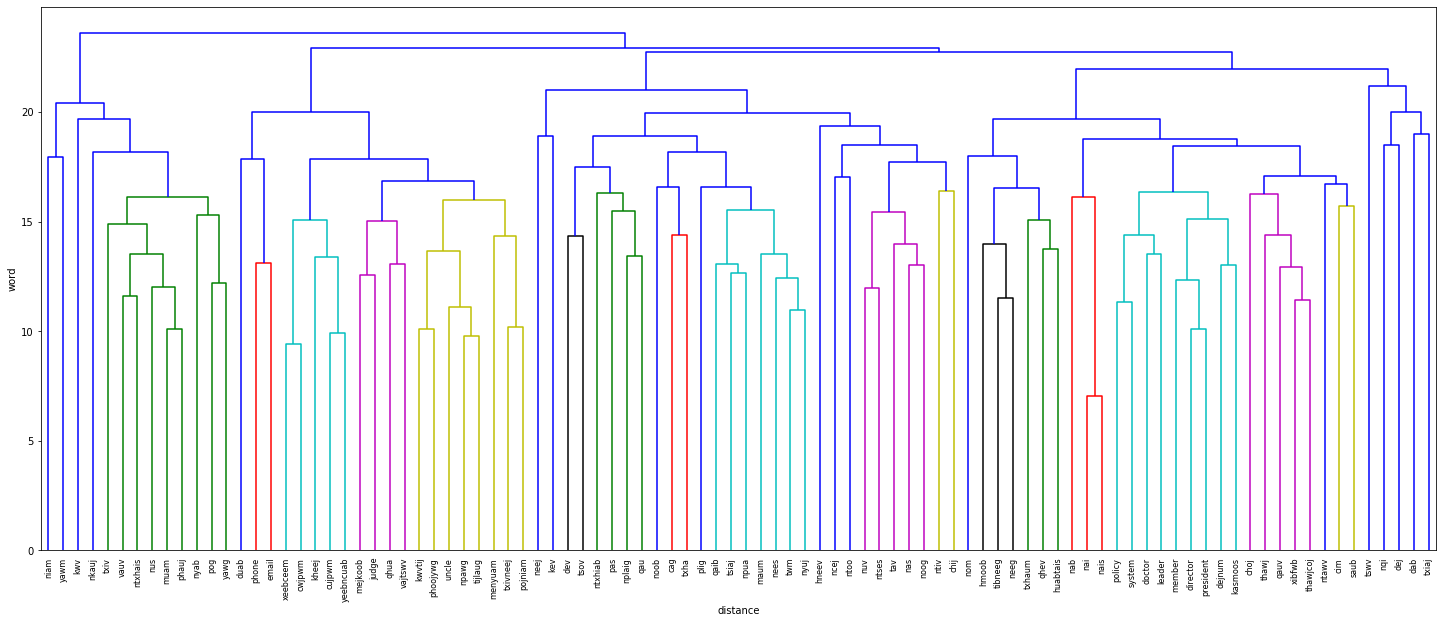

In [27]:
l = linkage(total_proc_vectors, method='complete', metric='seuclidean')
plt.figure(figsize=(25,10))
plt.ylabel('word')
plt.xlabel('distance')
dendrogram(l, leaf_font_size=8., leaf_rotation=90., leaf_label_func=lambda v: total_proc[v])
plt.show()

In [18]:
import pickle
f = open('Word2Vec_model_50.pkl', 'wb')
pickle.dump(model, f)
f.close()

In [13]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

In [19]:
# from geeksforgeeks.com
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,20)

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=30, max_iter=300, random_state=0).fit(total_proc_vectors)
    distortions.append(sum(np.min(cdist(total_proc_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(total_proc_vectors[0]))
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(total_proc_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(total_proc_vectors[0])
    mapping2[k] = kmeanModel.inertia_

In [20]:
for key, val in mapping2.items():
    print(str(key)+' : '+str(val))

1 : 80497.10977657659
2 : 75291.11948287807
3 : 72209.17173441003
4 : 69473.6010738263
5 : 67403.74004503971
6 : 66360.27839124468
7 : 64799.06576820979
8 : 63143.11082236788
9 : 62155.35208900178
10 : 60301.29531721639
11 : 59440.771400816535
12 : 57934.895542763414
13 : 57032.16260874864
14 : 55495.43224494191
15 : 54114.46917100402
16 : 53150.90522825718
17 : 51004.852981880635
18 : 49945.77321458314
19 : 49575.97540608872


In [21]:
import matplotlib.pyplot as plt

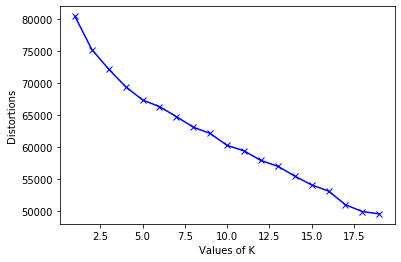

In [25]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortions')
plt.show()

In [49]:
km = KMeans(n_clusters=7, init='random', n_init=30, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(total_proc_vectors)

In [46]:
print(y_km)

[6 5 6 6 4 6 5 3 5 5 0 6 4 5 5 6 0 0 6 6 0 5 5 4 6 3 0 5 0 6 3 6 5 0 5 0 4
 5 6 3 6 4 2 5 6 1 5 3 4 1 3 2 2 0 1 3 4 5 6 6 4 6 6 1 3 6 4 0 6 2 5 4 0 6
 6 5 6 6 6 5 0 6 1 3 3 5 6 6 4 5 6 0 4 1]


In [28]:
from itertools import groupby

In [50]:
outcomes = zip(y_km, total_proc, total_proc_english)
total_proc_grouped = groupby(sorted(outcomes, key=lambda x: x[0]), lambda x: x[0])
for key, group in total_proc_grouped:
    print(key)
    for item in group:
        print(item[1], "'" + item[2] + "'")
    print()

0
nqi 'price'
txiaj 'money'
tibneeg 'human being'
vajtswv 'God'
dab 'spirit'
dejnum 'responsibility'
neeg 'person'
mejkoob 'marriage negotiator'
choj 'bridge'
pojniam 'wife'
kev 'way'
hmoob 'Hmong'
duab 'image'
dej 'river'
txhaum 'mistake'
menyuam 'child'
neej 'life'

1
xibfwb 'pastor'
doctor 'doctor'
yawg 'grandfather'
chij 'flag'
tswv 'boss'
nai 'boss'
plig 'soul'
saub 'creator god'
nyab 'daughter-in-law'
thawj 'leader'
nom 'government official'
yawm 'grandfather'
qhev 'servant'
nab 'snake'
ntawv 'letter'
nais 'boss'
huabtais 'emperor'

2
niam 'mother'

3
pas 'stick'
nuv 'hook'
hneev 'crossbow'
ntses 'fish'
qau 'phallus'
ntiv 'finger'
ntoo 'tree trunk'
tav 'rib'
nplaig 'tongue'
ncej 'pillar'
noob 'seed'
cag 'root'
nas 'rat'
txha 'bone'

4
director 'director'
policy 'policy'
judge 'judge'
cujpwm 'behavior'
email 'email'
qauv 'form'
member 'member'
system 'system'
thawjcoj 'leader'
kasmoos 'politician'
yeebncuab 'enemy'
leader 'leader'
xeebceem 'characteristic'
cim 'symbol'
txivneej 'm

With seven groups, the results are interesting. 

While group 0 has an unclear semantic basis, group 1 is dominated by terms that refer to people with authority: _xibfwb_ 'pastor', _nai_ 'boss', _nom_ 'government official', and _huabtais_ 'emperor', for example. 

Group 3 likewise has mostly inanimate objects on the one hand--_pas_ 'stick', _nuv_ 'hook', _ntoo_ 'tree trunk'-- and body parts on the other--_nplaig_ 'tongue' and _txha_ 'bone', for example. 

Group 4 has English borrowings related to official and other professional concepts, including occupations, such as _director_, _judge_, _system_, and _policy_, some abstract Hmong terms--probably associated with official concepts--such as _xeebceem_ 'characteristic' and _cwjpwm_ 'behavior'.

Group 5 is almost a perfect fit for relationships--_phauj_ 'aunt', _kwvtij_ 'brothers', _phoojywg_ 'friend', and so on--while _niam_ 'mother' is alone in group 2 and _noog_ 'bird' is inexplicably in the group.

Group 6 is almost exclusively animal terms--_tsiaj_ 'animal', _npua_ 'pig', _twm_ 'water buffalo'--except for _ntxhiab_ 'scent', which makes sense as a term associated with animals.

Altogether, the results are a sensible first pass; however, improvements can be made. Obvious categories include 1) inanimate objects characterized by a straight, rigid shape, 2) similarly "straight" body parts, 3) official concepts, 4) professional roles, 5) professional concepts, 6) relationships, and 7) animals. The following words present special difficulty for this taxonomy of seven categories, and, unsurprisingly, were grouped together as a sort of "other" category: _nqi_ 'price', _duab_ 'image', _dej_ 'river', _txhaum_ 'mistake', _neej_ 'life', _txiaj_ 'money', _chij_ 'flag', _ntawv_ 'letter', and _noob_ 'seed'. This can be explained, however, by the fact that the relationship between these items and the larger categories are the likely result of literal and metaphorical, but idiosyncratic, semantic extensions.

In [34]:
km = KMeans(n_clusters=30, init='random', n_init=30, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(total_proc_vectors)

In [35]:
outcomes = zip(y_km, total_proc, total_proc_english)
total_proc_grouped = groupby(sorted(outcomes, key=lambda x: x[0]), lambda x: x[0])
for key, group in total_proc_grouped:
    print(key)
    for item in group:
        print(item[1], "'" + item[2] + "'")
    print()

0
ntxhais 'animal'
niam 'creator god'
maum 'brother'
menyuam 'president'

1
noob 'judge'

2
nom 'director'
huabtais 'grandfather'
qhev 'person'
kasmoos 'soul'

3
hmoob 'price'

4
saub 'government official'

5
judge 'phallus'
president 'spirit'
mejkoob 'finger'
director 'symbol'

6
nab 'money'
yawm 'boss'
yawg 'tree trunk'
choj 'seed'

7
txiaj 'behavior'

8
ntoo 'leader'

9
xeebceem 'phone'
cwjpwm 'rat'

10
npua 'marriage negotiator'
ntxhiab 'daughter-in-law'
nplaig 'pillar'
ntiv 'Hmong'
qau 'son-in-law'

11
dej 'pig'

12
member 'grandmother'
leader 'grandfather'

13
system 'policy'
policy 'servant'

14
txha 'responsibility'
pas 'politician'
ncej 'dog'

15
nas 'scent'
ntses 'leader'
nees 'tongue'
noog 'snake'
twm 'river'
tav 'female'
nuv 'emperor'

16
phone 'doctor'
email 'friend'

17
muam 'brothers'
txiv 'pastor'
uncle 'uncle'
qaib 'wife'
nus 'leader'
nyab 'brother'
vauv 'chicken'
phauj 'bone'
plig 'guest'
nyuj 'life'

18
nqi 'fish'

19
dejnum 'crossbow'
yeebncuab 'bird'
thawj 'form'
t